<a href="https://colab.research.google.com/github/gopalm-ai/Tensor-Networks/blob/main/Copy_of_T01_Quantum_Circuit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
if 'google.colab' in str(get_ipython()):
  # install packages required for this tutorial
  !pip install tensorflow==2.3.1
  !pip install tensorflow_quantum==0.4.0
  !pip install quple==0.7.8

# Tutorial-01 Quantum Circuit

In this tutorial, you will learn how to:

- Create a quantum circuit with customizable qubit layout
- Apply gate operations on specific set of qubits for a given circuit
- Parameterise a gate operation and resolve the parameters with custom input values
- Circuit simulation: statevector simulation and expectation simulation

In [2]:
import cirq
import numpy as np
import sympy as sp
import quple

## Create Quantum Circuits

- In quple, a base class for building quantum circuit is `quple.QuantumCircuit` which is derived from the `cirq.Circuits` class. So any methods applicable to `cirq.Circuits` can also be applied to `quple.QuantumCircuit`.
- The `QuantumCircuit` class accepts the following arguments:
 - `n_qubit`: If int, it specifies the number of qubits in the circuit.\
 If iterable of cirq.GridQubit object, it specifies the exact qubit layout of the circuit. 
 - `name`: Name of the circuit
 - `insert_strategy`: The insertion strategy of gate operations in the circuit. Default is cirq.circuits.InsertStrategy.INLINE
 - `backend`: The backend for circuit simulation. If None, defaults to the native TensorFlow simulator

In [3]:
from quple import QuantumCircuit

In [4]:
cq = QuantumCircuit(n_qubit=5, name='line_qubit_layout')
print('Qubit layout for the circuit "{}":'.format(cq.name))
# by default, a line qubit layout is used
cq.qubits

Qubit layout for the circuit "line_qubit_layout":


[cirq.GridQubit(0, 0),
 cirq.GridQubit(0, 1),
 cirq.GridQubit(0, 2),
 cirq.GridQubit(0, 3),
 cirq.GridQubit(0, 4)]

In [5]:
# now let's try a square grid qubit layout
qubits = cirq.GridQubit.rect(3, 3)
cq_2 = QuantumCircuit(n_qubit=qubits, name='square_qubit_layout')
print('Qubit layout for the circuit "{}":'.format(cq_2.name))
# by default, a line qubit layout is used
cq_2.qubits

Qubit layout for the circuit "square_qubit_layout":


[cirq.GridQubit(0, 0),
 cirq.GridQubit(0, 1),
 cirq.GridQubit(0, 2),
 cirq.GridQubit(1, 0),
 cirq.GridQubit(1, 1),
 cirq.GridQubit(1, 2),
 cirq.GridQubit(2, 0),
 cirq.GridQubit(2, 1),
 cirq.GridQubit(2, 2)]

## Apply gate operations

- `QuantumCircuit` allows for easy application of gate operations with the following features:
 - Most gate operations are appened to the `QuantumCircuit` class methods. The gate operation can also be accessed by specifying its corresponding string representation.
 - Evey qubit in the circuit is represented by an index. So the target qubit(s) of a gate operation can be specified purely by the qubits' numeric indices. 

### Construction of the quantum circuit for a Bell state

In [6]:
# Creates a circuit with 2 qubits
cq = QuantumCircuit(2, name='BellCircuit')
# Apply the Hadamard gate to the qubit with index 0 
cq.H(0)
# Apply the CNOT gate to qubits with indices 0 and 1
# with the first one being the control qubit
cq.CNOT((0,1))
# Print out the circuit diagram
cq

(0, 0): ───H───@───
               │
(0, 1): ───────X───

### Construction of a more complicated quantum circuit

In [9]:
# Creates a circuit with 5 qubits
cq = QuantumCircuit(5)
# Apply the Hadamard gate to all qubits
cq.H(cq.qubits)
# Apply the RZ gates to qubits 2,3 and 4 with a rotation angle of pi/4 
cq.RZ(sp.pi/4, cq.qubits[2:5])
# to make the circuit diagram looks less tangled for 2-qubit gates use the NEW insert strategy instead
cq.set_insert_strategy(cirq.circuits.InsertStrategy.NEW)
# Apply the CNOT gates to the qubit pairs (0, 1), (1, 3), (2, 4)
cq.CNOT([(0, 1), (1, 3), (2,4)])
# Print out the circuit diagram
cq

(0, 0): ───H──────────────@───────────
                          │
(0, 1): ───H──────────────X───@───────
                              │
(0, 2): ───H───Rz(pi/4)───────┼───@───
                              │   │
(0, 3): ───H───Rz(pi/4)───────X───┼───
                                  │
(0, 4): ───H───Rz(pi/4)───────────X───

Another approach to applying gate operation to a quantum circuit is via the `appply_gate_operation` method

The arguments are:

apply_gate_operation(operation:[str, cirq.Gate], qubit_expr, params=None)

In [10]:
# Creates a circuit with 5 qubits
cq = QuantumCircuit(5)
# Apply the Hadamard gate to all qubits
cq.apply_gate_operation('H', cq.qubits)
# Apply the RZ gates to qubits 2,3 and 4 with a rotation angle of pi/4 
cq.apply_gate_operation('RZ', cq.qubits[2:5], {'rads': sp.pi/4})
# to make the circuit diagram looks less tangled for 2-qubit gates use the NEW insert strategy instead
cq.set_insert_strategy(cirq.circuits.InsertStrategy.NEW)
# Apply the CNOT gate to the qubit pairs (0, 1), (1, 3), (2, 4)
cq.apply_gate_operation('CNOT', [(0, 1), (1, 3), (2,4)])
# Apply the SWAP gate to the qubit pairs (3,4)
cq.apply_gate_operation('SWAP', (3,4))
# Print out the circuit diagram
cq

(0, 0): ───H──────────────@───────────────
                          │
(0, 1): ───H──────────────X───@───────────
                              │
(0, 2): ───H───Rz(pi/4)───────┼───@───────
                              │   │
(0, 3): ───H───Rz(pi/4)───────X───┼───×───
                                  │   │
(0, 4): ───H───Rz(pi/4)───────────X───×───

In [11]:
# to check the list of mapping from string to gate operations:
from quple.circuits.quantum_circuit import kGateMapping
kGateMapping

{'CCNOT': cirq.TOFFOLI,
 'CCX': cirq.TOFFOLI,
 'CNOT': cirq.CNOT,
 'CNOTPowGate': cirq.ops.common_gates.CXPowGate,
 'CSWAP': cirq.FREDKIN,
 'CX': cirq.CNOT,
 'CXPowGate': cirq.ops.common_gates.CXPowGate,
 'CZ': cirq.CZ,
 'CZPowGate': cirq.ops.common_gates.CZPowGate,
 'FSim': cirq.ops.fsim_gate.FSimGate,
 'Fredkin': cirq.FREDKIN,
 'H': cirq.H,
 'I': cirq.I,
 'ISWAP': cirq.ISWAP,
 'MS': <function cirq.ion.ion_gates.ms>,
 'PauliRotation': quple.components.gate_ops.PauliRotation,
 'PauliX': cirq.X,
 'PauliY': cirq.Y,
 'PauliZ': cirq.Z,
 'RISWAP': <function cirq.ops.swap_gates.riswap>,
 'RX': <function cirq.ops.common_gates.rx>,
 'RXX': <function quple.components.gate_ops.RXX>,
 'RY': <function cirq.ops.common_gates.ry>,
 'RYY': <function quple.components.gate_ops.RYY>,
 'RZ': <function cirq.ops.common_gates.rz>,
 'RZZ': <function quple.components.gate_ops.RZZ>,
 'S': cirq.S,
 'SWAP': cirq.SWAP,
 'T': cirq.T,
 'Toffoli': cirq.TOFFOLI,
 'X': cirq.X,
 'XPowGate': cirq.ops.common_gates.XPowGat

### Appending circuits/ Combining circuits

In [12]:
# create two circuits with 3 qubits
cq_1 = QuantumCircuit(3)
cq_1.H(cq_1.qubits)
cq_2 = QuantumCircuit(3)
cq_2.X(cq_1.qubits)
print('circuit 1:')
print(cq_1)
print()
print('circuit 2:')
print(cq_2)

circuit 1:
(0, 0): ───H───

(0, 1): ───H───

(0, 2): ───H───

circuit 2:
(0, 0): ───X───

(0, 1): ───X───

(0, 2): ───X───


In [13]:
# create a third circuit that is a combination of the above two circuits
cq_3 = cq_1 + cq_2
cq_3

(0, 0): ───H───X───

(0, 1): ───H───X───

(0, 2): ───H───X───

In [14]:
# alternatively, append the 2nd circuit to the 1st in place
cq_1 += cq_2
cq_1

(0, 0): ───H───X───

(0, 1): ───H───X───

(0, 2): ───H───X───

## Parameterise a gate operation

In [15]:
# Creates a circuit with 2 qubits
cq = QuantumCircuit(2)
# Parameterize the angle of an RZ operation on qubit 0 by "theta_0"
theta_0 = sp.Symbol('θ_0')
cq.RZ(theta_0, 0)
# Parameterize the angle of an RZ operation on qubit 1 by "theta_1"
theta_1 = sp.Symbol('θ_1')
cq.RZ(theta_1, 1)
# Parameterize the angle of an RZZ operation on the qubit pair (0, 1) with qubit 1 being the target qubit by "theta_0*theta_1"
cq.PauliRotation('ZZ', theta_0*theta_1, (0, 1))
cq

(0, 0): ───Rz(θ_0)───@─────────────────@───
                     │                 │
(0, 1): ───Rz(θ_1)───X───Rz(θ_0*θ_1)───X───

In [16]:
#check the circuit symbols
cq.symbols

['θ_0', 'θ_1']

### Circuit flattening

To more efficiently resolve parameter symbols to specified values for a complicated circuits, it is better to flatten the circuit so that each "expression" in a gate operation is regarded as an independent symbol

In [17]:
# flatten the circuit
cq.flatten()
cq

(0, 0): ───Rz(pi*<θ_0/pi>)───@─────────────────────────@───
                             │                         │
(0, 1): ───Rz(pi*<θ_1/pi>)───X───Rz(pi*<θ_0*θ_1/pi>)───X───

In [18]:
# now check the symbols again
cq.symbols

['<θ_0*θ_1/pi>', '<θ_0/pi>', '<θ_1/pi>']

In [19]:
# get get the original symbols after flattening:
cq.raw_symbols

['θ_0', 'θ_1']

In [20]:
# unflatten the circuit
cq.unflatten()
cq

(0, 0): ───Rz(θ_0)───@─────────────────@───
                     │                 │
(0, 1): ───Rz(θ_1)───X───Rz(θ_0*θ_1)───X───

### Resolve parameters of a circuit

To obtain circuit with its paramterised gate operations resolved by some designated values, one can use the `resolve_parameters` method

In [21]:
# resolve the values:  theta_0 = 0, theta_1 = pi/2
resolved_cq = cq.resolve_parameters(np.array([[0, np.pi/2]]))
resolved_cq

(0, 0): ───Rz(0)──────@───────────@───
                      │           │
(0, 1): ───Rz(0.5π)───X───Rz(0)───X───

In [22]:
# this also work for flattened circuit the usual way
cq.flatten()
resolved_cq = cq.resolve_parameters(np.array([[0, np.pi/2]]))
resolved_cq

(0, 0): ───Rz(0)──────@───────────@───
                      │           │
(0, 1): ───Rz(0.5π)───X───Rz(0)───X───

In [23]:
cq.unflatten()

In [24]:
# resolve multiple set of values:  
# [(theta_0 = 0, theta_1 = pi/2), (theta_0 = pi/3, theta_1 = pi/4)]
resolved_cqs = cq.resolve_parameters(np.array([[0, np.pi/2], [np.pi/3, np.pi/4]]))
print('------------------------------------------------')
print('resolved circuit 0:')
print(resolved_cqs[0])
print('------------------------------------------------')
print('resolved circuit 1:')
print(resolved_cqs[1])
print('------------------------------------------------')

------------------------------------------------
resolved circuit 0:
(0, 0): ───Rz(0)──────@───────────@───
                      │           │
(0, 1): ───Rz(0.5π)───X───Rz(0)───X───
------------------------------------------------
resolved circuit 1:
(0, 0): ───Rz(0.333π)───@────────────────@───
                        │                │
(0, 1): ───Rz(0.25π)────X───Rz(0.262π)───X───
------------------------------------------------


In [25]:
n_circuit = 5
# let's try some random values from -pi to pi
random_values = np.random.uniform(-np.pi, np.pi, (n_circuit, len(cq.symbols)))
resolved_cqs = cq.resolve_parameters(random_values)
for c in resolved_cqs:
    print('------------------------------------------------')
    print(c)
print('------------------------------------------------')

------------------------------------------------
(0, 0): ───Rz(0.366π)───@────────────────@───
                        │                │
(0, 1): ───Rz(0.671π)───X───Rz(0.773π)───X───
------------------------------------------------
(0, 0): ───Rz(-0.201π)───@────────────────@───
                         │                │
(0, 1): ───Rz(-0.193π)───X───Rz(0.122π)───X───
------------------------------------------------
(0, 0): ───Rz(-0.651π)───@───────────────@───
                         │               │
(0, 1): ───Rz(-0.935π)───X───Rz(1.91π)───X───
------------------------------------------------
(0, 0): ───Rz(-0.028π)───@─────────────────@───
                         │                 │
(0, 1): ───Rz(0.716π)────X───Rz(-0.062π)───X───
------------------------------------------------
(0, 0): ───Rz(0.281π)────@─────────────────@───
                         │                 │
(0, 1): ───Rz(-0.575π)───X───Rz(-0.506π)───X───
------------------------------------------------


## Circuit simulation

The `QuantumCircuit` class has two build-in methods for easy statevector and expectation simulation which uses the `tensorflow_quantum` layers.

Alternative, one can simply treat a `QuantumCircuit` instance as a `cirq.Circuit` instance and perform simulation using cirq or tensorflow quantum build-in utilities

### statevector simulation

To perform statevector simulation, simply use the `get_state_vectors` method from `QuantumCircuit`

The arguments are:
- vals: The values feeded to the parameter resolver. Default is None for the case of a non-parameterised circuit. If dict, it represents the map from sympy.Symbol objects to symbol values. If list of dict, it represents a list of parameter resolvers each with a map from sympy.Symbol objects to symbol values. If numpy array, it represents a mapping of symbol values according to the symbol indices.

In [26]:
# let's check the statevector for a Bell circuit
cq = QuantumCircuit(2, name='BellCircuit')
cq.H(0)
cq.CNOT((0,1))
cq

(0, 0): ───H───@───
               │
(0, 1): ───────X───

In [27]:
cq.get_state_vectors()

array([[7.0710677e-01-1.2802769e-08j, 0.0000000e+00+0.0000000e+00j,
        2.7021173e-15-3.0908620e-08j, 7.0710677e-01+6.1817239e-08j]],
      dtype=complex64)

In [28]:
# let's check the statevector for a simple parameterised circuit
cq = QuantumCircuit(2)
cq.H([0, 1])
cq.RZ(sp.Symbol('x'), [0, 1])
cq.CNOT((0,1))
cq

(0, 0): ───H───Rz(x)───@───
                       │
(0, 1): ───H───Rz(x)───X───

In [29]:
# resolve the values of the symbol x from 0 to 2pi with intervals of 200
symbol_values = np.linspace(0, 2*np.pi, 200)
symbol_values = symbol_values.reshape((200, 1))
state_vectors = cq.get_state_vectors(symbol_values)
state_vectors[0]

array([0.49999997-1.81058493e-08j, 0.49999997+1.28027695e-08j,
       0.49999997+4.37113883e-08j, 0.49999997+1.28027704e-08j],
      dtype=complex64)

### expecation simulation

To perform expectation simulation, simply use the `get_expectation` method from `QuantumCircuit`

The arguments are:
- vals: The values feeded to the parameter resolver. Default is None for the case of a non-parameterised circuit. If dict, it represents the map from sympy.Symbol objects to symbol values. If list of dict, it represents a list of parameter resolvers each with a map from sympy.Symbol objects to symbol values. If numpy array, it represents a mapping of symbol values according to the symbol indices.
- operators: cirq operators for measuring the expecation value. If None, defaults to the PauliZ operator in the first qubit.
- repetitions: Number of measurement for computing the expecation. Default is 5000.

In [35]:
# let's check the expectation for the first qubit for a Bell circuit
cq = QuantumCircuit(2, name='BellCircuit')
cq.H(0)
cq.CNOT((0,1))
cq

(0, 0): ───H───@───
               │
(0, 1): ───────X───

In [36]:
result = cq.get_expectation(operators=[cirq.Z(qubits[0]), cirq.Z(qubits[1])], repetitions=5000)
print(result)

[[-0.0044 -0.0044]]


We can see that both qubits have expectation 0 for the PauliZ operator. This means for both qubits, they have equal probability of being in the spin up (i.e. measured Z value is 1) or spin down (i.e. measured Z value is -1) states

In [37]:
# let's check the expectation for a simple parameterised circuit
cq = QuantumCircuit(1)
cq.RX(sp.Symbol('x'), 0)
cq

(0, 0): ───Rx(x)───

In [38]:
symbol_values = np.linspace(0, 2*np.pi, 200)
symbol_values = symbol_values.reshape((200, 1))
result = cq.get_expectation(symbol_values)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.7/dist-packages/matplotlib/pyplot.py'>

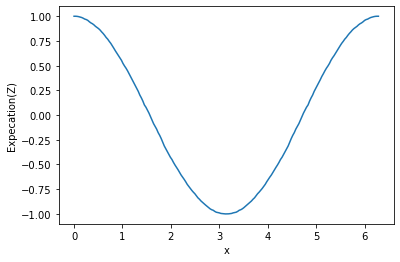

In [39]:
import matplotlib.pyplot as plt
x = np.linspace(0, 2*np.pi, 200)
y = result.reshape((200))
plt.plot(x, y)
plt.xlabel('x')
plt.ylabel('Expecation(Z)')
plt